In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
!pip install python_speech_features

In [15]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from __future__ import print_function
import sys
import os
import numpy as np


In [16]:
from python_speech_features import mfcc
from sklearn import preprocessing
import scipy.io.wavfile as wav




In [17]:
def tf_x_init(fan_in, fan_out, dtype=np.float32):
    k =  np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval=-k, maxval=k, dtype=dtype)


def sample_bernoulli(probs):
    return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))



In [18]:

class RBM:
    def __init__(self,
                 n_visible,
                 n_hidden,
                 learning_rate=0.01,
                 momentum=0.95,
                 err_function='mse',
                 use_tqdm=False,
                 # DEPRECATED:
                 tqdm=None):
        if not 0.0 <= momentum <= 1.0:
            raise ValueError('momentum should be in range [0, 1]')

       

        self._use_tqdm = use_tqdm
        self._tqdm = None

        if use_tqdm or tqdm is not None:
            from tqdm import tqdm
            self._tqdm = tqdm

        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.momentum = momentum

        self.x = tf.placeholder(tf.float32, [None, self.n_visible])
        self.y = tf.placeholder(tf.float32, [None, self.n_hidden])

        self.w = tf.Variable(tf_x_init(self.n_visible, self.n_hidden), dtype=tf.float32)
        self.visible_bias = tf.Variable(tf.zeros([self.n_visible]), dtype=tf.float32)
        self.hidden_bias = tf.Variable(tf.zeros([self.n_hidden]), dtype=tf.float32)

        self.delta_w = tf.Variable(tf.zeros([self.n_visible, self.n_hidden]), dtype=tf.float32)
        self.delta_visible_bias = tf.Variable(tf.zeros([self.n_visible]), dtype=tf.float32)
        self.delta_hidden_bias = tf.Variable(tf.zeros([self.n_hidden]), dtype=tf.float32)

        self.update_weights = None
        self.update_deltas = None
        self.compute_hidden = None
        self.compute_visible = None
        self.compute_visible_from_hidden = None

        self._initialize_vars()

        assert self.update_weights is not None
        assert self.update_deltas is not None
        assert self.compute_hidden is not None
        assert self.compute_visible is not None
        assert self.compute_visible_from_hidden is not None

        
        self.compute_err = tf.reduce_mean(tf.square(self.x - self.compute_visible))

        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)

    def _initialize_vars(self):
        pass

    def get_err(self, batch_x):
        return self.sess.run(self.compute_err, feed_dict={self.x: batch_x})



    def partial_fit(self, batch_x):
        self.sess.run(self.update_weights + self.update_deltas, feed_dict={self.x: batch_x})

    def fit(self,
            data_x,
            n_epoches=10,
            batch_size=10,
            shuffle=True,
            verbose=True):
        assert n_epoches > 0

        n_data = data_x.shape[0]

        if batch_size > 0:
            n_batches = n_data // batch_size + (0 if n_data % batch_size == 0 else 1)
        else:
            n_batches = 1

        if shuffle:
            data_x_cpy = data_x.copy()
            inds = np.arange(n_data)
        else:
            data_x_cpy = data_x

        errs = []

        for e in range(n_epoches):
            if verbose and not self._use_tqdm:
                print('Epoch: {:d}'.format(e))

            epoch_errs = np.zeros((n_batches,))
            epoch_errs_ptr = 0

            if shuffle:
                np.random.shuffle(inds)
                data_x_cpy = data_x_cpy[inds]

            r_batches = range(n_batches)

            if verbose and self._use_tqdm:
                r_batches = self._tqdm(r_batches, desc='Epoch: {:d}'.format(e), ascii=True, file=sys.stdout)

            for b in r_batches:
                batch_x = data_x_cpy[b * batch_size:(b + 1) * batch_size]
                self.partial_fit(batch_x)
                batch_err = self.get_err(batch_x)
                epoch_errs[epoch_errs_ptr] = batch_err
                epoch_errs_ptr += 1

            if verbose:
                err_mean = epoch_errs.mean()
                if self._use_tqdm:
                    self._tqdm.write('Train error: {:.4f}'.format(err_mean))
                    self._tqdm.write('')
                else:
                    print('Train error: {:.4f}'.format(err_mean))
                    print('')
                sys.stdout.flush()

            errs = np.hstack([errs, epoch_errs])

        return errs

    def get_weights(self):
        return self.sess.run(self.w),\
            self.sess.run(self.visible_bias),\
            self.sess.run(self.hidden_bias)

    def save_weights(self, filename, name):
        saver = tf.train.Saver({name + '_w': self.w,
                                name + '_v': self.visible_bias,
                                name + '_h': self.hidden_bias})
        return saver.save(self.sess, filename)

    def set_weights(self, w, visible_bias, hidden_bias):
        self.sess.run(self.w.assign(w))
        self.sess.run(self.visible_bias.assign(visible_bias))
        self.sess.run(self.hidden_bias.assign(hidden_bias))

    def load_weights(self, filename, name):
        saver = tf.train.Saver({name + '_w': self.w,
                                name + '_v': self.visible_bias,
                                name + '_h': self.hidden_bias})
        saver.restore(self.sess, filename)


In [19]:

class GBRBM(RBM):
    def __init__(self, n_visible, n_hidden, **kwargs):
       

        RBM.__init__(self, n_visible, n_hidden, **kwargs)

    def _initialize_vars(self):
        hidden_p = tf.nn.sigmoid(tf.matmul(self.x, self.w) + self.hidden_bias)
        visible_recon_p = tf.matmul(sample_bernoulli(hidden_p), tf.transpose(self.w)) + self.visible_bias

        

        hidden_recon_p = tf.nn.sigmoid(tf.matmul(visible_recon_p, self.w) + self.hidden_bias)

        positive_grad = tf.matmul(tf.transpose(self.x), hidden_p)
        negative_grad = tf.matmul(tf.transpose(visible_recon_p), hidden_recon_p)

        def f(x_old, x_new):
            return self.momentum * x_old +\
                   self.learning_rate * x_new * (1 - self.momentum) / tf.to_float(tf.shape(x_new)[0])

        delta_w_new = f(self.delta_w, positive_grad - negative_grad)
        delta_visible_bias_new = f(self.delta_visible_bias, tf.reduce_mean(self.x - visible_recon_p, 0))
        delta_hidden_bias_new = f(self.delta_hidden_bias, tf.reduce_mean(hidden_p - hidden_recon_p, 0))

        update_delta_w = self.delta_w.assign(delta_w_new)
        update_delta_visible_bias = self.delta_visible_bias.assign(delta_visible_bias_new)
        update_delta_hidden_bias = self.delta_hidden_bias.assign(delta_hidden_bias_new)

        update_w = self.w.assign(self.w + delta_w_new)
        update_visible_bias = self.visible_bias.assign(self.visible_bias + delta_visible_bias_new)
        update_hidden_bias = self.hidden_bias.assign(self.hidden_bias + delta_hidden_bias_new)

        self.update_deltas = [update_delta_w, update_delta_visible_bias, update_delta_hidden_bias]
        self.update_weights = [update_w, update_visible_bias, update_hidden_bias]

        self.compute_hidden = tf.nn.sigmoid(tf.matmul(self.x, self.w) + self.hidden_bias)
        self.compute_visible = tf.matmul(self.compute_hidden, tf.transpose(self.w)) + self.visible_bias
        self.compute_visible_from_hidden = tf.matmul(self.y, tf.transpose(self.w)) + self.visible_bias


In [ ]:
# data preprocessor
# Here Bulk data is preprocessed to use in training


In [20]:
shift = 1
merge_limit=4
dataset = []


#name of the file where urbm model learned weights and biases will be saved.
save_weights_path = "/content/gdrive/My Drive/SpeakerVerification/SavedModels/urbm_model" 


lr  = 0.001
input_dim =80
hidden_dim = 400
batch_size = 100
nb_epoch = 100

# this is the directory where all test wav data
# each file corresponds to each speaker
path_dir = "/content/gdrive/My Drive/SpeakerVerification/Data/" 
file_list=os.listdir(path_dir)

print(file_list)



['file_example_WAV_2MG.wav', 'taunt.wav', 'StarWars60.wav', 'StarWars3.wav', 'ortalking.wav', '3peopletalking.wav', 'OSR_us_000_0010_8k.wav', 'OSR_us_000_0011_8k.wav', 'OSR_us_000_0012_8k.wav', 'OSR_us_000_0013_8k.wav', 'OSR_us_000_0030_8k.wav', 'OSR_us_000_0031_8k.wav', 'OSR_us_000_0032_8k.wav', 'OSR_us_000_0034_8k.wav', 'OSR_us_000_0035_8k.wav', 'OSR_us_000_0036_8k.wav', '2.wav', '3.wav']


In [41]:
# vector 
import numpy as np

supervector_list=[]

for f in file_list:
    if(f.endswith(".wav")==False):
        continue

    # we skip one file here.
    if(f.endswith("3.wav")==True):
        continue;

    gbrbm = GBRBM(n_visible=input_dim, n_hidden=hidden_dim, learning_rate=lr, momentum=0.95, use_tqdm=True)
    gbrbm.load_weights(save_weights_path+f,'weights'+f)
    w,b_bias,h_bias = gbrbm.get_weights()

    w=np.reshape(w,80*400)
    supervector=np.concatenate((w,b_bias,h_bias),axis=None)
    # print(supervector.size)
    # supervector=preprocessing.scale(supervector) # mean normalization of supervectors
    # print(supervector)
    supervector_list.append(supervector)


# fit current size of the ram
# trunk_sv_list=[]
# for item in supervector_list:
#     new_item=item[:15000]
#     trunk_sv_list.append(new_item)
# trunk_vectors= np.array(trunk_sv_list)
# print(trunk_vectors.shape)
#

supervector_data=np.array(supervector_list)
#normal
supervector_data=preprocessing.scale(supervector_data, axis=0)

# gbrbm = GBRBM(n_visible=input_dim, n_hidden=hidden_dim, learning_rate=lr, momentum=0.95, use_tqdm=True)
# gbrbm.load_weights(save_weights_path,'weights')
# w,b_bias,h_bias = gbrbm.get_weights()

# w=np.reshape(w,80*400)
# urbm_supervector=np.concatenate((w,b_bias,h_bias),axis=None)
# print(supervector.size)
# u_vector=preprocessing.scale(urbm_supervector) # mean normalization of supervectors


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/SpeakerVerification/SavedModels/urbm_modelfile_example_WAV_2MG.wav
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/SpeakerVerification/SavedModels/urbm_modeltaunt.wav
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/SpeakerVerification/SavedModels/urbm_modelStarWars60.wav
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/SpeakerVerification/SavedModels/urbm_modelortalking.wav
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/SpeakerVerification/SavedModels/urbm_model3peopletalking.wav
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/SpeakerVerification/SavedModels/urbm_modelOSR_us_000_0010_8k.wav
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/SpeakerVerification/SavedModels/urbm_modelOSR_us_000_0011_8k.wav
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/SpeakerVerification/SavedModels/urbm_mode

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [ ]:
# PCA whitening and dimensionality reduction  ...
import numpy as np
from sklearn.decomposition import PCA
pca = PCA()
X=supervector_data
pca.fit(X)
rbm_vectors= pca.transform(X)

print(rbm_vectors.shape)
print(rbm_vectors)

In [38]:
# clustering tasks starts here ...
# clustering 2
from sklearn.cluster import AgglomerativeClustering
X=rbm_vectors
clustering = AgglomerativeClustering(n_clusters=6, linkage='average').fit(X)


print(clustering.labels_)




[3 0 5 0 4 2 2 2 2 1 1 1 1 1 1 0]


{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'b',
  'b',
  'b'],
 'dcoord': [[0.0, 118.89448247116974, 118.89448247116974, 0.0],
  [0.0, 119.4581130658999, 119.4581130658999, 118.89448247116974],
  [0.0, 131.07998751557113, 131.07998751557113, 119.4581130658999],
  [0.0, 175.89753442226538, 175.89753442226538, 0.0],
  [0.0, 129.92079155868066, 129.92079155868066, 0.0],
  [0.0, 130.79183261308276, 130.79183261308276, 0.0],
  [0.0, 133.26594602565154, 133.26594602565154, 130.79183261308276],
  [129.92079155868066,
   133.61267804662933,
   133.61267804662933,
   133.26594602565154],
  [0.0, 178.7067389040147, 178.7067389040147, 133.61267804662933],
  [175.89753442226538, 190.883423644944, 190.883423644944, 178.7067389040147],
  [0.0, 192.70099329698127, 192.70099329698127, 190.883423644944],
  [131.07998751557113,
   195.22545429779944,
   195.22545429779944,
   192.70099329698127],
  [0.0, 257.5940146920763, 257.5940146920763, 195.2

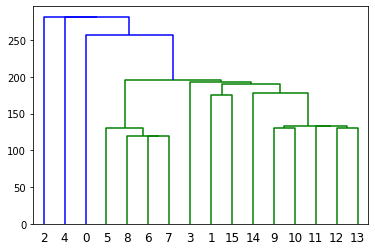

In [43]:
from scipy.cluster.hierarchy import dendrogram, linkage
z=linkage(X)
dendrogram(z)

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/SpeakerVerification/SavedModels/urbm_model3.wav
(17, 17)
[[-7.71388006e+00  1.33765976e+02  1.27403049e+01  1.86171875e+02
  -6.62423630e+01 -2.42275887e+01 -1.07663670e+01  6.79015398e+00
  -2.85293162e-02  9.05217767e-01 -1.48033774e+00  1.50721061e+00
   5.76488912e-01  1.03080702e+00 -7.52959251e-01 -9.78982210e-01
  -1.60778873e-05]
 [-8.43568230e+00  4.06139526e+01  8.68574524e+00  1.48929996e+01
   2.16620045e+01  8.05141830e+01  4.96884003e+01 -6.17787895e+01
   6.34672117e+00  1.92739582e+01 -1.76755161e+01  6.25808668e+00
  -1.62713737e+01  2.36159039e+00  3.68149948e+00 -2.02494812e+01
  -4.42280434e-05]
 [-1.46350060e+01  1.02505852e+02  2.03336136e+02 -1.11439964e+02
  -4.70462685e+01 -1.18205566e+01 -5.27471542e+00  4.12530088e+00
  -2.27486324e+00  8.75460923e-01  1.34511483e+00  1.43739605e+00
   2.23152590e+00  9.55693603e-01 -9.46223736e-01 -3.01221460e-01
  -7.22706318e-07]
 [ 1.31302612e+02  5.869368

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'b',
  'b',
  'b'],
 'dcoord': [[0.0, 118.31487283568423, 118.31487283568423, 0.0],
  [0.0, 118.68756539291704, 118.68756539291704, 118.31487283568423],
  [0.0, 130.48097040819104, 130.48097040819104, 118.68756539291704],
  [0.0, 129.78972341111074, 129.78972341111074, 0.0],
  [0.0, 171.9397971137509, 171.9397971137509, 129.78972341111074],
  [0.0, 129.18387274640213, 129.18387274640213, 0.0],
  [0.0, 130.0278377586506, 130.0278377586506, 0.0],
  [0.0, 132.48912265585147, 132.48912265585147, 130.0278377586506],
  [129.18387274640213,
   133.01717620771467,
   133.01717620771467,
   132.48912265585147],
  [0.0, 177.848472195628, 177.848472195628, 133.01717620771467],
  [171.9397971137509,
   190.55916576390618,
   190.55916576390618,
   177.848472195628],
  [0.0, 191.20921184360174, 191.20921184360174, 190.55916576390618],
  [130.48097040819104,
   195.00649444091556,
   195.006494

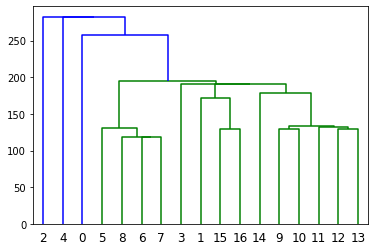

In [44]:
#Adding a new file to get new cluster..

# vector 
import numpy as np
import numpy as np
from sklearn.decomposition import PCA



f='3.wav'

gbrbm = GBRBM(n_visible=input_dim, n_hidden=hidden_dim, learning_rate=lr, momentum=0.95, use_tqdm=True)
gbrbm.load_weights(save_weights_path+f,'weights'+f)
w,b_bias,h_bias = gbrbm.get_weights()

w=np.reshape(w,80*400)
supervector=np.concatenate((w,b_bias,h_bias),axis=None)
# print(supervector.size)
# supervector=preprocessing.scale(supervector) # mean normalization of supervectors
# print(supervector)
supervector_list.append(supervector)


# fit current size of the ram
# trunk_sv_list=[]
# for item in supervector_list:
#     new_item=item[:15000]
#     trunk_sv_list.append(new_item)
# trunk_vectors= np.array(trunk_sv_list)
# print(trunk_vectors.shape)
#

supervector_data=np.array(supervector_list)
#normal
supervector_data=preprocessing.scale(supervector_data, axis=0)


pca = PCA()
X=supervector_data
pca.fit(X)
rbm_vectors= pca.transform(X)

print(rbm_vectors.shape)
print(rbm_vectors)

z=linkage(X)
dendrogram(z)